In [1]:
from __future__ import print_function

# ignore some Keras warnings regarding deprecations and model saving 
import warnings
warnings.filterwarnings('ignore')

from keras.models import Model, load_model
from keras.layers import Input, LSTM, Dense
import pickle

from helpers import *
import importlib
from importlib import reload
from scipy.stats import hmean

Using TensorFlow backend.


Sentences from the [tatoeba dataset](https://tatoeba.org/eng/downloads)

In [2]:
batch_size = 128  # Batch size for training.
epochs = 20  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples =200000 # Number of samples to train on.
# Path to the datatxt file on disk.
data_path = 'sentences.txt'

epochs = 100
noise = 0.05
misspellings_count = 3
chunk_size = 40000

optimizer= 'adam'
loss_fn='categorical_crossentropy'


In [3]:
# Hand-pick maximum sequence lengths
max_encoder_seq_length = 25
max_decoder_seq_length = 30

In [4]:
def load_preprocessed(data_path):
    with open(data_path) as f:
        lines = f.readlines()
    lines = text_preprocess(lines)
    # allow only for a limited count of 
    allowed_chars = {'.', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', 
             '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', 
             '5', '6', '7', '8', '9', ':', ';', '?', '[', ']', 
             '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 
             'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 
             's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '}' }
    selected = []
    for l in lines:
        if all([c in allowed_chars for c in l.strip()]) and \
           len(l) < max_encoder_seq_length:
            selected.append(l)
    # suffle deterministically
    Random(0).shuffle(selected)
    return selected

In [5]:
all_phrases = load_preprocessed(data_path)
input_phrases = all_phrases[:num_samples]
test_phrases = all_phrases[num_samples:]
print('All phrases in dataset: ', len(all_phrases))
print('Training phrases: ', len(input_phrases))
print('Test phrases: ', len(test_phrases))

print("\n * ".join(['Examples:'] + all_phrases[:10]))

All phrases in dataset:  210139
Training phrases:  200000
Test phrases:  10139
Examples:
 * leave him alone, please
 * what do you call love?
 * tom got in the taxi
 * we can trust tom
 * i'd like you to meet tom
 * the money is terrible
 * did you go to see him?
 * monday will be a hot day
 * tom took mary to dinner
 * turn on the light please


In [6]:
# create doken indices out of all phrases
input_token_index = token_index(all_phrases)
num_encoder_tokens = len(input_token_index)
target_token_index = {'\t': num_encoder_tokens, 
                      '\n': num_encoder_tokens+1, 
                      **input_token_index}
num_decoder_tokens = len(target_token_index)

# Keep the count of all the possible input characters

print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)

Number of unique input tokens: 55
Number of unique output tokens: 57


In [7]:
def models(num_encoder_tokens, num_decoder_tokens, latent_dim):
    # Define an input sequence and process it.
    encoder_inputs = Input(shape=(None, num_encoder_tokens), name='encoder_inputs')
    encoder = LSTM(latent_dim, return_state=True, name='encoder')
    encoder_outputs, state_h, state_c = encoder(encoder_inputs)
    # We discard `encoder_outputs` and only keep the states.
    encoder_states = [state_h, state_c]

    # Set up the decoder, using `encoder_states` as initial state.
    decoder_inputs = Input(shape=(None, num_decoder_tokens), name='decoder_inputs')
    # We set up our decoder to return full output sequences,
    # and to return internal states as well. We don't use the
    # return states in the training model, but we will use them in inference.
    decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, 
                        name='decoder_lstm')
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                         initial_state=encoder_states)
    decoder_dense = Dense(num_decoder_tokens, activation='softmax', 
                          name='decoder_dense')
    decoder_outputs = decoder_dense(decoder_outputs)

    # Define the model that will turn
    # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

    # Next: inference mode (sampling).
    # Here's the drill:
    # 1) encode input and retrieve initial decoder state
    # 2) run one step of decoder with this initial state
    # and a "start of sequence" token as target.
    # Output will be the next target token
    # 3) Repeat with the current target token and current states

    # Define sampling models
    encoder_model = Model(encoder_inputs, encoder_states)

    decoder_state_input_h = Input(shape=(latent_dim,), name='decoder_input_h')
    decoder_state_input_c = Input(shape=(latent_dim,), name='decoder_input_c')
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    decoder_outputs, state_h, state_c = decoder_lstm(
        decoder_inputs, initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)

    decoder_model = Model(
        [decoder_inputs] + decoder_states_inputs,
        [decoder_outputs] + decoder_states)
    
    return model, encoder_model, decoder_model


In [8]:
model, encoder_model, decoder_model = models(num_encoder_tokens, num_decoder_tokens, latent_dim)

model.compile(optimizer=optimizer, loss=loss_fn)

Train few epochs on an identity fn with a chunk of the dataset for sanity

In [9]:
train_input_phrases = input_phrases[:10000]
X, Y = vectorize_dataset(train_input_phrases, wrap_with_delims(train_input_phrases),
                  input_token_index,target_token_index,
                  max_encoder_seq_length, max_decoder_seq_length)

Train on 9000 samples, validate on 1000 samples
Epoch 1/100
9000/9000 [==============================] - 10s 1ms/step - loss: 2.0636 - val_loss: 1.8943
Epoch 2/100
9000/9000 [==============================] - 9s 1ms/step - loss: 1.8237 - val_loss: 1.7181
Epoch 3/100
9000/9000 [==============================] - 9s 1ms/step - loss: 1.6187 - val_loss: 1.5311
Epoch 4/100
9000/9000 [==============================] - 9s 1ms/step - loss: 1.4799 - val_loss: 1.4688
Epoch 5/100
9000/9000 [==============================] - 9s 1ms/step - loss: 1.4185 - val_loss: 1.3774
Epoch 6/100
9000/9000 [==============================] - 9s 1ms/step - loss: 1.3446 - val_loss: 1.3240
Epoch 7/100
9000/9000 [==============================] - 9s 1ms/step - loss: 1.2901 - val_loss: 1.2637
Epoch 8/100
9000/9000 [==============================] - 9s 1ms/step - loss: 1.2411 - val_loss: 1.2104
Epoch 9/100
9000/9000 [==============================] - 9s 1ms/step - loss: 1.2033 - val_loss: 1.1754
Epoch 10/100
9000/9000 [

9000/9000 [==============================] - 11s 1ms/step - loss: 0.0986 - val_loss: 0.2514
Epoch 80/100
9000/9000 [==============================] - 11s 1ms/step - loss: 0.0946 - val_loss: 0.2463
Epoch 81/100
9000/9000 [==============================] - 11s 1ms/step - loss: 0.0901 - val_loss: 0.2383
Epoch 82/100
9000/9000 [==============================] - 11s 1ms/step - loss: 0.0946 - val_loss: 0.2541
Epoch 83/100
9000/9000 [==============================] - 11s 1ms/step - loss: 0.0835 - val_loss: 0.2723
Epoch 84/100
9000/9000 [==============================] - 12s 1ms/step - loss: 0.0834 - val_loss: 0.2402
Epoch 85/100
9000/9000 [==============================] - 11s 1ms/step - loss: 0.0763 - val_loss: 0.2481
Epoch 86/100
9000/9000 [==============================] - 11s 1ms/step - loss: 0.0811 - val_loss: 0.2400
Epoch 87/100
9000/9000 [==============================] - 11s 1ms/step - loss: 0.0765 - val_loss: 0.2358
Epoch 88/100
9000/9000 [==============================] - 11s 1ms/st

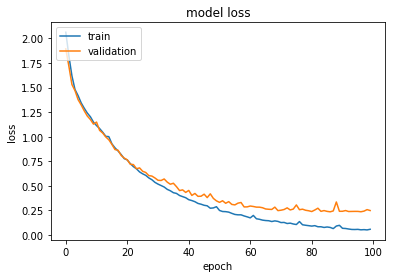

In [10]:
history = model.fit(X,Y,
                   batch_size=batch_size, epochs=epochs, 
                   validation_split=0.1)
plot_history(history)

Create a "corrector" fn that will "translate" our misspelled input to a right one

In [11]:
corrector = translate_fn(encoder_model, decoder_model, 
                         input_token_index, target_token_index,
                        max_encoder_seq_length)

In [12]:
# let's see what our model has learned so far
# by trying to "correct" some correct phrases
[corrector(p) for p in train_input_phrases[:10]]

['leave him alone pescead',
 'what do you lacl ovel?',
 'tom got in the taxt',
 'we can trust tom',
 "i'd like you to meet tom",
 'the money is terrible',
 'did you go to see him?',
 'monday will be a hot day',
 'tom took mary to dinner',
 'turn on the light please']

In [13]:
def evaluate_correct(texts, corrector):
    errors = 0.0
    for t in texts:
        if t != corrector(t): errors += 1
    return errors / len(texts)

def evaluate_misspelled(texts, corrector):
    errors = 0.0
    for t in texts:
        errored = add_noise_to_string(t, 0.05)
        if t != corrector(errored): errors += 1
    return errors / len(texts)

In [14]:
evaluate_correct(train_input_phrases[:100], corrector)

0.44

In [15]:
evaluate_misspelled(train_input_phrases[:100], corrector)

0.71

In [16]:
def training_vectorizer_fn(input_token_index, max_encoder_seq_length,
                           target_token_index, max_decoder_seq_length):
    # create a closure fn that "knows" the token indices and seq lengths
    def training_vectorizer(input_texts, target_texts):
        encoder_input_data = vectorize_batch(input_texts, input_token_index,
                                             max_encoder_seq_length)
        decoder_input_data = vectorize_batch(target_texts, target_token_index,
                                             max_decoder_seq_length)
                # same as decoder input data, but offset by one
        decoder_output_data = vectorize_batch(target_texts, target_token_index,
                                              max_decoder_seq_length, True)
        X = [encoder_input_data, decoder_input_data]
        Y = decoder_output_data
        return X, Y

    return training_vectorizer

# Create a training_vectorizer that only accepts input and target texts
training_vectorizer = training_vectorizer_fn(input_token_index, max_encoder_seq_length,
                                             target_token_index, max_decoder_seq_length)

In [17]:
def batched_gen(phrases, batch_size, misspellings_count, noise):
    """Goes through the given phrases, in `batch_size` batches, generating 
    `misspellings_count` misspelling allongside them.
    On each iteration it yields `batch_size`* (1+ misspellings_count) strings: 
    the original strings and the misspellings generated out of them"""
    for i in range(0, len(phrases), batch_size):
        frrom = i
        to = i+batch_size
        print("Yielding phrases from #%d to #%d" % (frrom, to))
        yield create_misspellings(phrases[frrom:to], noise, misspellings_count)

In [18]:
tst = batched_gen(input_phrases, 3, 2, 0.07)
inp, trgt = next(tst)
for i,t in zip(inp, trgt):
    print(i, '->',t)

Yielding phrases from #0 to #3
leave him alone, please -> leave him alone, please
what do you call love? -> what do you call love?
tom got in the taxi -> tom got in the taxi
leave him alone, please -> leave him alone, please
what do yu call love? -> what do you call love?
tom gtok in thebtaxi -> tom got in the taxi
leave hm alone, please -> leave him alone, please
wha tdo you call xloye? -> what do you call love?
tom got in th qaxi -> tom got in the taxi


In [19]:
def vectorized_gen(phrases, batch_size, misspellings_count, noise,
                   training_vectorizer):
    """Creates vextorized batches of phrases (that are wrapped with delims)"""
    # Create a generator of misspelled strings from the input phrases
    gen = batched_gen(phrases, batch_size, misspellings_count, noise)
    
    # Go through all the input phrases, generatiing misspellings, vectorizing them
    # and yielding each batch
    for input_phrases, target_phrases in gen:
        target_phrases = wrap_with_delims(target_phrases)
        X, Y = training_vectorizer(input_phrases, target_phrases)
        # Yield the data in a X, Y form
        yield (X, Y)

In [20]:
# create a final generator holding all the context
def training_generator():
    gen = vectorized_gen(input_phrases, chunk_size,
                         misspellings_count, noise,
                         training_vectorizer)
    yield from gen

In [21]:
loss, val, test = [], [], []

for epoch in range(epochs):
    print("(Real) Epoch: %s" % epoch)
    # Initialize the generator
    gen = training_generator()
    
    
    l, v, t = [], [], []
    for X, Y in gen:
        h = model.fit(X, Y,
                batch_size=batch_size,epochs=1, validation_split=0.1)
        test_err = evaluate_misspelled(test_phrases[:1000], corrector)
        print('Test Error:', test_err)
        l.append(h.history['loss'][0])
        v.append(h.history['val_loss'][0])
        t.append(test_err)
    
    loss.append(hmean(l))
    val.append(hmean(v))
    test.append(hmean(t))
        


(Real) Epoch: 0
Yielding phrases from #0 to #40000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 180s 1ms/step - loss: 0.2883 - val_loss: 0.2838
Test Error: 0.822
Yielding phrases from #40000 to #80000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 191s 1ms/step - loss: 0.2258 - val_loss: 0.2262
Test Error: 0.78
Yielding phrases from #80000 to #120000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 191s 1ms/step - loss: 0.1873 - val_loss: 0.1967
Test Error: 0.727
Yielding phrases from #120000 to #160000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 189s 1ms/step - loss: 0.1585 - val_loss: 0.1702
Test Error: 0.663
Yielding phrases from #160000 to #200000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [=========

144000/144000 [==============================] - 156s 1ms/step - loss: 0.0456 - val_loss: 0.0573
Test Error: 0.363
Yielding phrases from #120000 to #160000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 158s 1ms/step - loss: 0.0448 - val_loss: 0.0554
Test Error: 0.346
Yielding phrases from #160000 to #200000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 158s 1ms/step - loss: 0.0447 - val_loss: 0.0561
Test Error: 0.353
(Real) Epoch: 8
Yielding phrases from #0 to #40000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 160s 1ms/step - loss: 0.0439 - val_loss: 0.0553
Test Error: 0.353
Yielding phrases from #40000 to #80000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 165s 1ms/step - loss: 0.0438 - val_loss: 0.0532
Test Error: 0.37
Yielding p

Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 183s 1ms/step - loss: 0.0344 - val_loss: 0.0434
Test Error: 0.302
Yielding phrases from #40000 to #80000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 182s 1ms/step - loss: 0.0344 - val_loss: 0.0448
Test Error: 0.3
Yielding phrases from #80000 to #120000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 179s 1ms/step - loss: 0.0341 - val_loss: 0.0446
Test Error: 0.306
Yielding phrases from #120000 to #160000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 177s 1ms/step - loss: 0.0340 - val_loss: 0.0434
Test Error: 0.319
Yielding phrases from #160000 to #200000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 177s 1ms/step - loss: 0.034

144000/144000 [==============================] - 149s 1ms/step - loss: 0.0302 - val_loss: 0.0374
Test Error: 0.291
Yielding phrases from #120000 to #160000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 167s 1ms/step - loss: 0.0298 - val_loss: 0.0383
Test Error: 0.257
Yielding phrases from #160000 to #200000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 176s 1ms/step - loss: 0.0297 - val_loss: 0.0381
Test Error: 0.269
(Real) Epoch: 23
Yielding phrases from #0 to #40000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 173s 1ms/step - loss: 0.0298 - val_loss: 0.0388
Test Error: 0.278
Yielding phrases from #40000 to #80000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 171s 1ms/step - loss: 0.0299 - val_loss: 0.0396
Test Error: 0.286
Yielding

Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 154s 1ms/step - loss: 0.0275 - val_loss: 0.0351
Test Error: 0.286
Yielding phrases from #40000 to #80000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 154s 1ms/step - loss: 0.0273 - val_loss: 0.0355
Test Error: 0.261
Yielding phrases from #80000 to #120000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 155s 1ms/step - loss: 0.0273 - val_loss: 0.0360
Test Error: 0.274
Yielding phrases from #120000 to #160000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 190s 1ms/step - loss: 0.0274 - val_loss: 0.0354
Test Error: 0.254
Yielding phrases from #160000 to #200000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 190s 1ms/step - loss: 0.0

144000/144000 [==============================] - 161s 1ms/step - loss: 0.0259 - val_loss: 0.0321
Test Error: 0.247
Yielding phrases from #120000 to #160000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 166s 1ms/step - loss: 0.0257 - val_loss: 0.0321
Test Error: 0.269
Yielding phrases from #160000 to #200000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 166s 1ms/step - loss: 0.0259 - val_loss: 0.0337
Test Error: 0.264
(Real) Epoch: 38
Yielding phrases from #0 to #40000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 167s 1ms/step - loss: 0.0257 - val_loss: 0.0333
Test Error: 0.257
Yielding phrases from #40000 to #80000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 171s 1ms/step - loss: 0.0257 - val_loss: 0.0349
Test Error: 0.256
Yielding

Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 190s 1ms/step - loss: 0.0247 - val_loss: 0.0321
Test Error: 0.231
Yielding phrases from #40000 to #80000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 189s 1ms/step - loss: 0.0246 - val_loss: 0.0322
Test Error: 0.265
Yielding phrases from #80000 to #120000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 179s 1ms/step - loss: 0.0245 - val_loss: 0.0314
Test Error: 0.278
Yielding phrases from #120000 to #160000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 179s 1ms/step - loss: 0.0243 - val_loss: 0.0318
Test Error: 0.24
Yielding phrases from #160000 to #200000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 179s 1ms/step - loss: 0.02

144000/144000 [==============================] - 187s 1ms/step - loss: 0.0239 - val_loss: 0.0300
Test Error: 0.223
Yielding phrases from #120000 to #160000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 190s 1ms/step - loss: 0.0236 - val_loss: 0.0308
Test Error: 0.259
Yielding phrases from #160000 to #200000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 190s 1ms/step - loss: 0.0235 - val_loss: 0.0311
Test Error: 0.247
(Real) Epoch: 53
Yielding phrases from #0 to #40000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 154s 1ms/step - loss: 0.0233 - val_loss: 0.0309
Test Error: 0.241
Yielding phrases from #40000 to #80000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 150s 1ms/step - loss: 0.0232 - val_loss: 0.0314
Test Error: 0.257
Yielding

Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 150s 1ms/step - loss: 0.0228 - val_loss: 0.0296
Test Error: 0.241
Yielding phrases from #40000 to #80000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 149s 1ms/step - loss: 0.0228 - val_loss: 0.0300
Test Error: 0.245
Yielding phrases from #80000 to #120000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 153s 1ms/step - loss: 0.0228 - val_loss: 0.0300
Test Error: 0.242
Yielding phrases from #120000 to #160000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 156s 1ms/step - loss: 0.0226 - val_loss: 0.0312
Test Error: 0.227
Yielding phrases from #160000 to #200000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 156s 1ms/step - loss: 0.0

144000/144000 [==============================] - 153s 1ms/step - loss: 0.0221 - val_loss: 0.0286
Test Error: 0.251
Yielding phrases from #120000 to #160000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 153s 1ms/step - loss: 0.0221 - val_loss: 0.0289
Test Error: 0.239
Yielding phrases from #160000 to #200000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 153s 1ms/step - loss: 0.0222 - val_loss: 0.0294
Test Error: 0.237
(Real) Epoch: 68
Yielding phrases from #0 to #40000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 183s 1ms/step - loss: 0.0224 - val_loss: 0.0284
Test Error: 0.225
Yielding phrases from #40000 to #80000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 189s 1ms/step - loss: 0.0220 - val_loss: 0.0298
Test Error: 0.234
Yielding

Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 169s 1ms/step - loss: 0.0218 - val_loss: 0.0288
Test Error: 0.217
Yielding phrases from #40000 to #80000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 170s 1ms/step - loss: 0.0217 - val_loss: 0.0285
Test Error: 0.232
Yielding phrases from #80000 to #120000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 173s 1ms/step - loss: 0.0216 - val_loss: 0.0285
Test Error: 0.245
Yielding phrases from #120000 to #160000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 173s 1ms/step - loss: 0.0216 - val_loss: 0.0284
Test Error: 0.24
Yielding phrases from #160000 to #200000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 173s 1ms/step - loss: 0.02

144000/144000 [==============================] - 152s 1ms/step - loss: 0.0213 - val_loss: 0.0274
Test Error: 0.232
Yielding phrases from #120000 to #160000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 154s 1ms/step - loss: 0.0210 - val_loss: 0.0274
Test Error: 0.241
Yielding phrases from #160000 to #200000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 154s 1ms/step - loss: 0.0212 - val_loss: 0.0273
Test Error: 0.226
(Real) Epoch: 83
Yielding phrases from #0 to #40000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 154s 1ms/step - loss: 0.0210 - val_loss: 0.0276
Test Error: 0.251
Yielding phrases from #40000 to #80000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 174s 1ms/step - loss: 0.0211 - val_loss: 0.0278
Test Error: 0.24
Yielding 

Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 180s 1ms/step - loss: 0.0206 - val_loss: 0.0279
Test Error: 0.216
Yielding phrases from #40000 to #80000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 180s 1ms/step - loss: 0.0207 - val_loss: 0.0278
Test Error: 0.242
Yielding phrases from #80000 to #120000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 172s 1ms/step - loss: 0.0206 - val_loss: 0.0273
Test Error: 0.216
Yielding phrases from #120000 to #160000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 170s 1ms/step - loss: 0.0206 - val_loss: 0.0272
Test Error: 0.208
Yielding phrases from #160000 to #200000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 171s 1ms/step - loss: 0.0

144000/144000 [==============================] - 180s 1ms/step - loss: 0.0205 - val_loss: 0.0279
Test Error: 0.231
Yielding phrases from #120000 to #160000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 181s 1ms/step - loss: 0.0203 - val_loss: 0.0264
Test Error: 0.232
Yielding phrases from #160000 to #200000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 180s 1ms/step - loss: 0.0204 - val_loss: 0.0276
Test Error: 0.236
(Real) Epoch: 98
Yielding phrases from #0 to #40000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 181s 1ms/step - loss: 0.0203 - val_loss: 0.0273
Test Error: 0.236
Yielding phrases from #40000 to #80000
Train on 144000 samples, validate on 16000 samples
Epoch 1/1
144000/144000 [==============================] - 187s 1ms/step - loss: 0.0202 - val_loss: 0.0274
Test Error: 0.213
Yielding

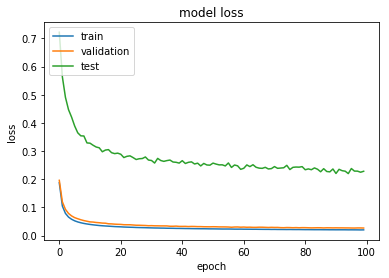

In [22]:
plt.plot(loss)
plt.plot(val)
plt.plot(test)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation', 'test'], loc='upper left')
plt.show()

In [29]:
test[-3:]

[0.22892326419479278, 0.22503219045288073, 0.228476861809285]

In [23]:
evaluate_correct(input_phrases[:1000], corrector)

0.005

In [24]:
evaluate_correct(input_phrases[-1000:], corrector)

0.002

In [25]:
evaluate_misspelled(input_phrases[:1000], corrector)

0.179

In [26]:
evaluate_correct(test_phrases[:1000], corrector)

0.077

In [27]:
evaluate_misspelled(test_phrases[:1000], corrector)

0.214

In [30]:
def evaluate_vect(input_texts, target_texts, model, training_vectorizer):
    target_texts = wrap_with_delims(target_texts)
    
    #wrapped_target_texts = wrap_with_delims(target_texts)
    X, Y = training_vectorizer(input_texts, target_texts)
    loss = model.evaluate(X, Y)
    print('\nTesting loss: ', loss)


In [31]:
misspelled = [add_noise_to_string(p, .05) for p in test_phrases[:1000]]
evaluate_vect(misspelled, test_phrases[:1000],
              model, training_vectorizer)

1000/1000 [==============================] - 0s 358us/step

Testing loss:  0.04364998284727335


In [32]:
# find max encoder seq legth
#max_encoder_seq_length = encoder_model.get_layer('encoder_inputs').input_shape[-1]
phrases = ['fire', 'stp', 'comein', 'get ot', 'i cant go','im sorry', 
           'h is busi', 'hes drunk', 'ill be lat', 'hold mi beer', 'pus the buton', 
          'coll me on my phone', 'helo boys and girls']

[corrector(phrase) for phrase in phrases]

['fire',
 'stop',
 'come in',
 'get out',
 "i can't go",
 "i'm sorry",
 'he is busy',
 "he's drunk",
 "i'll be late",
 'hold it beer',
 'pus the button',
 'coll me on my phone',
 'hello boys and girls']

In [33]:
def save():
    """quick-n-dirty helper for saving models"""
    print("Saving model")
    model.save('training.h5')
    encoder_model.save('encoder.h5')
    decoder_model.save('decoder.h5')

    model_metadata = { 'input_token_index': input_token_index, 
                       'target_token_index': target_token_index,
                       'max_encoder_seq_length': max_encoder_seq_length }

    with open('model_metadata.pickle', 'wb') as f:
        pickle.dump(model_metadata, f)

In [34]:
save()

Saving model
